In [1]:
import torch.multiprocessing as mp
mp.set_start_method('spawn', force=True)

# Предсказание цены автомобиля при помощи нейронной сети

**В этом ноутбуке мы последовательно:**
- Установим и импортируем нужные библиотеки
- Очистим данные и добавим новые информативные признаки
- Подготовим выборки, закодируем и масштабируем признаки
- Построим нейросетевую модель

## 1. Установка и импорт

In [23]:
import pandas as pd, numpy as np, math, joblib, gc, warnings, os, random, json, pickle, time
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# Импортируем библиотеки, фиксируем сиды и выбираем устройство.
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tqdm.pandas()


 ## 2. Загрузка данных

In [5]:
CARS_FILE_ID = '1liFEe1-yFISPSpRSvbv1wIH_avYNGmBI'
RANDOM_STATE = 42

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

!gdown --id {CARS_FILE_ID}

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1liFEe1-yFISPSpRSvbv1wIH_avYNGmBI
From (redirected): https://drive.google.com/uc?id=1liFEe1-yFISPSpRSvbv1wIH_avYNGmBI&confirm=t&uuid=f0b6d54f-76aa-4901-8b3f-7ed96a4cd871
To: /kaggle/working/dataset.csv
100%|██████████████████████████████████████| 1.01G/1.01G [00:13<00:00, 74.0MB/s]


In [6]:
def mem_usage(df):
    return f'{df.memory_usage(deep=True).sum()/1024**2:.1f} MB'

df = pd.read_csv('dataset.csv', low_memory=False)
print(f'RAW shape        : {df.shape}, mem: {mem_usage(df)}')

print('\nHead:')
display(df.head())

RAW shape        : (604047, 24), mem: 1458.8 MB

Head:


,production_year,mileage,condition,owners_number,pts_original,horse_power,accidents_resolution,region,seller_type,brand,...,engine_displacement,engine_power,fuel_rate,steering_wheel,price,price_segment,tags,auto_class,equipment,complectation_available_options
0,2020,31000,CONDITION_OK,0,NaN,170.0,OK,Оренбург,COMMERCIAL,Abarth,...,1368.0,170.0,6.6,LEFT,1900000,MEDIUM,allowed_for_credit;auction_call_free_report;au...,S,sport-suspension;seats-2,NaN
1,2017,96000,CONDITION_OK,0,NaN,170.0,OK,Оренбург,COMMERCIAL,Abarth,...,1368.0,170.0,6.4,LEFT,2300000,MEDIUM,allowed_for_credit;auction_call_free_report;au...,S,seats-2,NaN
2,2019,42500,CONDITION_OK,1,True,179.0,OK,Санкт-Петербург,PRIVATE,Abarth,...,1368.0,180.0,5.8,LEFT,2895000,MEDIUM,allowed_for_credit;auction_call_free_report;au...,A,seats-4,NaN
3,2013,130000,CONDITION_OK,2,True,160.0,OK,Москва,PRIVATE,Abarth,...,1368.0,160.0,5.4,LEFT,1750000,MEDIUM,allowed_for_credit;auction_call_free_report;av...,A,automatic-lighting-control;voice-recognition;l...,NaN
4,2009,47800,CONDITION_OK,4,True,135.0,OK,Москва,PRIVATE,Abarth,...,1368.0,135.0,6.5,LEFT,2000000,MEDIUM,allowed_for_credit;auction_call_free_report;au...,A,leather-gear-stick;seats-4;apple-carplay;usb;a...,NaN


## 3. Предобработка и признаки

In [7]:
# АНОМАЛИЯ
df.drop(210905, inplace=True)

df["fuel_rate"].fillna(df["fuel_rate"].median(), inplace=True)
df["pts_original"].fillna(True, inplace=True)
df["accidents_resolution"].fillna("OK", inplace=True)
df["auto_class"].fillna("NOT SPECIFIED", inplace=True)
df.drop("horse_power", axis=1, inplace=True)


def optimize_types(d):
    for col in d.select_dtypes(include=["int64"]).columns:
        d[col] = pd.to_numeric(d[col], downcast="integer")
    for col in d.select_dtypes(include=["float64"]).columns:
        d[col] = pd.to_numeric(d[col], downcast="float")
    return d


df = optimize_types(df)
print(f"After dtype optimisation mem: {mem_usage(df)}")


After dtype optimisation mem: 1420.9 MB


In [8]:
def split_max(x):
    try:
        return max(map(int, x.split(';')))
    except:
        return np.nan

df['seats_numeric'] = df['seats'].progress_apply(split_max)
df.drop('seats', axis=1, inplace=True)

  0%|          | 0/604046 [00:00<?, ?it/s]

### Преобразование мульти­категорий в дамми-признаки  
В этой ячейке мы:  
- Собираем все уникальные значения из колонок с «;»  
- Создаём бинарные столбцы для каждого уникального тега/опции/оборудования  
- Считаем, сколько элементов было в каждой строке

In [9]:
def get_uniques(series):
    u = set()
    for v in series.dropna():
        for w in v.split(";"):
            w = w.strip()
            if w:
                u.add(w)
    return list(u)


multi_cols = ["tags", "complectation_available_options", "equipment"]
uniques = {c: get_uniques(df[c]) for c in multi_cols}


def make_dummies(df, col, uniq):
    out = (
        df[col]
        .str.get_dummies(sep=";")
        .reindex(columns=uniq, fill_value=0)
        .astype("int8")
    )
    out.columns = [f"{col}__{c}" for c in uniq]
    df[f"{col}_cnt"] = df[col].progress_apply(
        lambda x: len(str(x).split(";")) if pd.notna(x) else 0
    )
    return out


tags_d = make_dummies(df, "tags", uniques["tags"])
opts_d = make_dummies(
    df,
    "complectation_available_options",
    uniques["complectation_available_options"],
).drop(columns=["complectation_available_options__condition"], errors="ignore")
eq_d = make_dummies(df, "equipment", uniques["equipment"]).drop(
    columns=["equipment__condition"], errors="ignore"
)

full = pd.concat([df.drop(multi_cols, axis=1), tags_d, opts_d, eq_d], axis=1)
del tags_d, opts_d, eq_d
gc.collect()
print("Dummies created, shape:", full.shape, "mem:", mem_usage(full))


  0%|          | 0/604046 [00:00<?, ?it/s]

  0%|          | 0/604046 [00:00<?, ?it/s]

  0%|          | 0/604046 [00:00<?, ?it/s]

Dummies created, shape: (604046, 590) mem: 753.8 MB


### Отбраковка сильно коррелирующих признаков
Здесь мы:

- Вычисляем корреляцию всех числовых признаков между собой

- Удаляем одну из пары признаков с корреляцией > 0.8

- Сохраняем важные столбцы (цену, год выпуска и счётчики мульти-категорий)

In [10]:
num = full.select_dtypes(include=["number"]).drop(
    columns=["price"], errors="ignore"
)

corr = num.corr().abs()
mask = np.triu(np.ones(corr.shape), 1).astype(bool)
upper = corr.where(mask)
mean_corr = corr.mean()

drop = set()
for i, j in zip(*np.where(upper > 0.80)):
    a, b = corr.index[i], corr.columns[j]
    drop.add(a if mean_corr[a] > mean_corr[b] else b)

# защищаем важные признаки от удаления
essential_cols = {
    "price",
    "production_year",  # уже были
    "tags_cnt",
    "equipment_cnt",
    "complectation_available_options_cnt",  # NEW
}
drop -= essential_cols

f = full.drop(columns=drop, errors="ignore").copy()
print("After corr-pruning shape:", f.shape)


After corr-pruning shape: (604046, 426)


### Создание новых признаков  
В этой ячейке мы:
- Добавляем полиномиальные признаки (год²), логарифмические трансформации и отношения (пробег в год, мощность на литр и т.п.)
- Рассчитываем возраст автомобиля и на его основе новые фичи: `age_x_power`, `power_per_year` и пр.
- Вводим булевы индикаторы: один владелец, новый автомобиль, «очень старый»
- Бинируем возраст и пробег в категории с помощью `pd.cut` и `pd.qcut`
- Удаляем исходные столбцы `production_year` и `engine_displacement`

In [11]:
# НОВЫЕ ПРИЗНАКИ
f["production_year_sq"] = f["production_year"] ** 2
f["age"] = 2025 - f["production_year"]
f["mileage_per_year"] = f["mileage"] / f["age"].clip(1)
f["log_mileage"] = np.log1p(f["mileage"])
f["power_per_liter"] = f["engine_power"] / f["engine_displacement"].clip(0.1)
f["age_x_power"] = f["age"] * f["engine_power"]
f["age_x_mileage"] = f["age"] * f["mileage"]
f["log_disp"] = np.log1p(f["engine_displacement"])
f["disp_per_door"] = f["engine_displacement"] / f["doors_count"].clip(1)
f["is_one_owner"] = (f["owners_number"] == 1).astype(int)
f["is_new"] = ((f["mileage"] < 1000) & (f["owners_number"] <= 1)).astype(int)
f["is_very_old"] = (f["age"] > 20).astype(int)
f["power_per_year"] = f["engine_power"] / (f["age"] + 1)
f["age_x_mileage"] = f["age"] * f["mileage"]  # уже был – перезаписываем, ок

f["age_bucket"] = pd.cut(
    f["age"], bins=[-1, 0, 3, 7, 12, 20, 35, 100, np.inf], labels=False
)
f["mileage_bucket"] = pd.qcut(
    f["mileage"], q=10, duplicates="drop", labels=False
)

# Убираем теперь ненужные столбцы
f.drop(["production_year", "engine_displacement"], axis=1, inplace=True)
print("Final feature DF shape:", f.shape)


Final feature DF shape: (604046, 439)


### Разбиение и подготовка данных  
- Делим на train/test (15%) и сбрасываем индексы  
- Применяем `log1p` к цене  
- Строим сглаженную среднюю цену по бренду и мержим её в оба датасета

In [12]:
train_df, test_df = train_test_split(f, test_size=0.15, random_state=SEED)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df["price_log"] = np.log1p(train_df["price"])
test_df["price_log"] = np.log1p(test_df["price"])

global_mean = train_df["price"].mean()
α = 10  # коэффициент сглаживания

smoothing_stats = (
    train_df.groupby("brand")["price"]
    .agg(["count", "mean"])
    .rename(columns={"count": "brand_count", "mean": "brand_mean"})
)

smoothing_stats["brand_price_smooth"] = (
    smoothing_stats["brand_mean"] * smoothing_stats["brand_count"]
    + global_mean * α
) / (smoothing_stats["brand_count"] + α)

# мёржим сглаженные значения
train_df = train_df.merge(
    smoothing_stats[["brand_price_smooth"]], on="brand", how="left"
)

test_df = test_df.merge(
    smoothing_stats["brand_price_smooth"], on="brand", how="left"
)

test_df["brand_price_smooth"].fillna(global_mean, inplace=True)


### OOF Target- и Frequency-Encoding категорий  
- Для каждого категориального признака из `cat_cols` выполняем KFold-оценку:  
  - Строим out-of-fold target-encoding на основе средней цены.  
  - Сохраняем карту средних для теста.  
- Одновременно считаем frequency-encoding (долю каждого значения) и добавляем в train/test.

In [13]:
cat_cols = [
    "condition",
    "accidents_resolution",
    "region",
    "seller_type",
    "brand",
    "model",
    "body_type",
    "steering_wheel",
    "price_segment",
    "auto_class",
]

te_maps = {}
freq_cols = []
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
global_mean = train_df["price"].mean()

for col in tqdm(cat_cols, desc="Target/Freq enc"):
    # OOF-target-encoding
    oof = pd.Series(index=train_df.index, dtype=float)
    for tr_idx, vl_idx in kf.split(train_df):
        means = train_df.iloc[tr_idx].groupby(col)["price"].mean()
        oof.iloc[vl_idx] = (
            train_df.iloc[vl_idx][col].map(means).fillna(global_mean)
        )
    train_df[col + "_te"] = oof
    te_map = train_df.groupby(col)["price"].mean()
    te_maps[col] = te_map
    test_df[col + "_te"] = test_df[col].map(te_map).fillna(global_mean)

    # freq-encoding
    freq = train_df[col].value_counts(normalize=True)
    train_df[col + "_fe"] = train_df[col].map(freq)
    test_df[col + "_fe"] = test_df[col].map(freq).fillna(0)
    freq_cols.append(col + "_fe")


Target/Freq enc:   0%|          | 0/10 [00:00<?, ?it/s]

### Масштабирование числовых признаков

подготавливаем числовые признаки к обучению модели:

- Собираем список всех числовых колонок: оригинальные (`num_cols`), таргет-энкодинги (`te_cols`) и частотные признаки (`freq_cols`).
- Удаляем из списка отсутствующие колонки (на случай, если они были отброшены ранее)
- Заполняем пропущенные значения нулями
- Применяем `StandardScaler` для нормализации всех признаков.

In [15]:
num_cols = [
    "mileage",
    "owners_number",
    "doors_count",
    "engine_power",
    "fuel_rate",
    "production_year_sq",
    "age",
    "mileage_per_year",
    "log_mileage",
    "power_per_liter",
    "age_x_power",
    "age_x_mileage",
    "log_disp",
    "disp_per_door",
    "is_one_owner",
    "is_new",
    "is_very_old",
    "power_per_year",
    "seats_numeric",
    "brand_price_smooth",
    "age_bucket",
    "mileage_bucket",
    "tags_cnt",
    "equipment_cnt",
    "complectation_available_options_cnt",
]

te_cols = [c + "_te" for c in cat_cols]
all_num = num_cols + freq_cols + te_cols

# убираем колонки, которых в DataFrame реально нет
all_num = [c for c in all_num if c in train_df.columns]

# заполняем возможные NaN, чтобы StandardScaler не упал
train_df[all_num] = train_df[all_num].fillna(0)
test_df[all_num] = test_df[all_num].fillna(0)

scaler = StandardScaler().fit(train_df[all_num])
joblib.dump(scaler, "scaler.pkl")

train_df[all_num] = scaler.transform(train_df[all_num])
test_df[all_num] = scaler.transform(test_df[all_num])


### Подготовка Dataset и DataLoader

In [33]:
class CarDataset(Dataset):
    def __init__(self, df, use_log=False):
        target = "price_log" if use_log else "price"
        self.y = torch.tensor(df[target].values, dtype=torch.float32)
        self.num = torch.tensor(df[all_num].values, dtype=torch.float32)
        self.cat = torch.tensor(df[label_code_cols].values, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.num[idx], self.cat[idx], self.y[idx]


batch = 256
train_loader = DataLoader(
    CarDataset(train_df), batch_size=batch, shuffle=True, num_workers=0
)
val_loader = DataLoader(
    CarDataset(test_df), batch_size=batch, shuffle=False, num_workers=0
)


## 5. Модель и обучение

### Определение нейросетевой модели `PriceNet`

Модель включает полносвязную нейросеть.  
Входной вектор состоит из числовых признаков (`all_num`).

Сеть имеет 2 скрытых слоя с `ReLU`, `BatchNorm` и `Dropout` для регуляризации, и один выходной слой

In [17]:
import torch
import torch.nn as nn


class PriceNet(nn.Module):
    def __init__(self):
        super().__init__()
        dim_in = len(all_num)
        self.net = nn.Sequential(
            nn.Linear(dim_in, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.20),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.15),
            nn.Linear(128, 1),
        )

    def forward(self, xn: torch.Tensor) -> torch.Tensor:
        return self.net(xn).squeeze(1)


### Настройка обучения  
- Инициализируем модель `PriceNet` на выбранном устройстве  
- Определяем оптимизатор AdamW с LR=3e-4 и weight decay  
- Используем планировщик `ReduceLROnPlateau` для автоматической корректировки LR  
- В качестве функции потерь — `SmoothL1Loss` (huber-like)


In [18]:
model = PriceNet().to(device)
opt   = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=7)
loss_fn = nn.SmoothL1Loss()

### Цикл обучения и валидации

In [19]:
EPOCHS = 500

for epoch in trange(1, EPOCHS + 1, desc="Epochs"):
    # ========== TRAIN ==========
    model.train()
    tr_loss = []
    for xn, _, y_price in train_loader:
        xn, y_price = xn.to(device), y_price.to(device)
        opt.zero_grad()
        preds_price = model(xn)
        loss = loss_fn(preds_price, y_price)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        tr_loss.append(loss.item())
    mean_train_loss = np.mean(tr_loss)

    # ========== VALIDATION ==========
    model.eval()
    all_preds, all_reals = [], []
    val_loss_list = []
    with torch.no_grad():
        for xn, _, y_price in val_loader:
            xn, y_price = xn.to(device), y_price.to(device)
            preds_tensor = model(xn)
            val_loss_list.append(loss_fn(preds_tensor, y_price).item())
            all_preds.append(preds_tensor.cpu().numpy())
            all_reals.append(y_price.cpu().numpy())

    mean_val_loss = np.mean(val_loss_list)

    preds = np.concatenate(all_preds)
    reals = np.concatenate(all_reals)

    rmse_price = mean_squared_error(reals, preds, squared=False)
    r2_price = r2_score(reals, preds)

    sched.step(mean_val_loss)

    if epoch % 5 == 0:
        print(
            f"Epoch {epoch:3d} | "
            f"Train Loss: {mean_train_loss:.4f} | "
            f"Val Loss:   {mean_val_loss:.4f} | "
            f"RMSE:       {rmse_price:.2f} | "
            f"R2:         {r2_price:.4f}"
        )
    else:
        print(
            f"Epoch {epoch:3d} | "
            f"Train Loss: {mean_train_loss:.4f} | "
            f"Val Loss:   {mean_val_loss:.4f} | "
            f"RMSE:       {rmse_price:.2f}"
        )


Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch   1 | Train Loss: 2807422.4604 | Val Loss:   2804539.0862 | RMSE:       6151936.00
Epoch   2 | Train Loss: 2807327.8958 | Val Loss:   2804383.6003 | RMSE:       6151864.50
Epoch   3 | Train Loss: 2807079.7150 | Val Loss:   2804135.1737 | RMSE:       6151745.50
Epoch   4 | Train Loss: 2806814.5933 | Val Loss:   2803793.0650 | RMSE:       6151590.00
Epoch   5 | Train Loss: 2806403.9852 | Val Loss:   2803359.5071 | RMSE:       6151393.50 | R2:         -0.2621
Epoch   6 | Train Loss: 2805918.0336 | Val Loss:   2802830.5925 | RMSE:       6151158.50
Epoch   7 | Train Loss: 2805268.4847 | Val Loss:   2802211.7097 | RMSE:       6150878.00
Epoch   8 | Train Loss: 2804824.8938 | Val Loss:   2801498.8821 | RMSE:       6150556.00
Epoch   9 | Train Loss: 2803926.1702 | Val Loss:   2800695.1758 | RMSE:       6150181.50
Epoch  10 | Train Loss: 2803126.0158 | Val Loss:   2799796.3121 | RMSE:       6149774.00 | R2:         -0.2615
Epoch  11 | Train Loss: 2802137.8222 | Val Loss:   2798805.9696 | 

### Визуализация кривых обучения  
Строим график изменения лосса на обучении и валидации по эпохам.

In [25]:
epochs = [x for x in range(1, 501)]
val_losses = [2804539.0862, 2804383.6003, 2804135.1737, 2803793.065, 2803359.5071, 2802830.5925, 2802211.7097, 2801498.8821, 2800695.1758, 2799796.3121, 2798805.9696, 2797722.1928, 2796548.1681, 2795278.4647, 2793917.5918, 2792461.3736, 2790917.9357, 2789279.3227, 2787548.7309, 2785725.0127, 2783808.6271, 2781799.298, 2779696.8658, 2777499.5, 2775213.3242, 2772837.5847, 2770363.4922, 2767797.0332, 2765138.8806, 2762384.1766, 2759540.5777, 2756610.4569, 2753604.5523, 2750491.4703, 2747241.4746, 2743964.6568, 2740582.1801, 2737105.0254, 2733487.548, 2729870.2225, 2726079.4075, 2722241.0346, 2718459.714, 2714528.7281, 2710712.9541, 2706528.4047, 2702198.7105, 2698196.185, 2693593.6751, 2689061.0819, 2684858.2888, 2680712.7069, 2676009.9082, 2671445.7154, 2667063.5148, 2662186.1758, 2657826.3093, 2652644.971, 2648474.4576, 2643051.6024, 2638731.9845, 2633929.1554, 2629165.2097, 2623884.065, 2619204.0085, 2613204.9269, 2609858.8404, 2602362.5169, 2597774.2687, 2593194.7482, 2587002.4499, 2582609.4149, 2576180.5279, 2571572.0805, 2566091.3641, 2561350.0911, 2555370.5053, 2549928.7987, 2544851.1275, 2540414.7225, 2535090.7595, 2529715.9435, 2521818.0378, 2516098.3167, 2509718.7977, 2505705.3517, 2499522.7571, 2493129.5787, 2488371.3616, 2482744.8097, 2476770.5145, 2470477.2302, 2462909.7814, 2457373.6698, 2453816.9174, 2447516.7948, 2441330.8217, 2434071.5936, 2425851.5198, 2420554.1681, 2413163.2083, 2410028.8016, 2403340.0653, 2396275.0505, 2389754.69, 2384145.1903, 2375310.5304, 2369160.81, 2361213.2412, 2353510.1924, 2352457.8305, 2337675.4262, 2336890.5046, 2328002.334, 2321371.9958, 2314867.4562, 2305463.8224, 2300818.3132, 2294064.4926, 2284200.6532, 2276149.5696, 2271029.048, 2260100.1536, 2254414.905, 2250152.791, 2238793.8997, 2234072.2034, 2225477.3079, 2218585.8023, 2213243.9015, 2205558.1624, 2193353.0424, 2189868.6095, 2179321.2489, 2173062.131, 2165261.1797, 2160076.4527, 2154895.9725, 2145899.9128, 2130954.0208, 2118536.881, 2119095.7348, 2113518.6568, 2105056.7797, 2101666.0388, 2084115.1773, 2081914.9629, 2080314.6197, 2059645.5208, 2056764.3164, 2049294.2133, 2034388.9725, 2030723.9389, 2026625.0441, 2013319.1554, 2007652.9735, 1993998.7641, 1982646.7634, 1981210.6847, 1978727.1211, 1965410.0395, 1948773.2899, 1948666.2097, 1931087.4852, 1921964.8757, 1922859.0438, 1908248.8517, 1886905.6095, 1882813.8418, 1887470.3291, 1875146.6949, 1856480.0463, 1860028.3005, 1842435.2609, 1839999.5879, 1835063.4792, 1799399.6254, 1820389.1642, 1791051.5879, 1789192.8199, 1791150.5569, 1775407.4276, 1752353.333, 1742960.666, 1755635.5611, 1717949.2945, 1728619.941, 1708781.7097, 1708908.7867, 1707068.8107, 1689601.209, 1665353.3739, 1648039.4986, 1636866.369, 1642751.1995, 1632281.4336, 1608124.66, 1624210.494, 1604728.7115, 1584631.1073, 1568498.7119, 1564796.797, 1563366.6653, 1549316.9661, 1536869.0279, 1522121.0761, 1494359.6352, 1504770.4047, 1493296.5288, 1465501.6365, 1477570.0132, 1452215.5508, 1433729.3944, 1416277.6137, 1403765.8081, 1392408.548, 1396894.1769, 1391900.419, 1366518.7498, 1371945.1419, 1339551.0104, 1331775.7652, 1302515.8879, 1297277.9859, 1271378.1169, 1271590.4913, 1259501.5141, 1245605.2016, 1252470.8377, 1208757.959, 1203816.5713, 1198680.1448, 1181750.4936, 1167550.2336, 1176086.212, 1135108.4174, 1143236.7906, 1114631.167, 1113781.398, 1086911.8829, 1094147.032, 1055789.1891, 1049285.4597, 1040098.6651, 1042314.6407, 1035720.6114, 1005239.9709, 991288.4181, 972297.5923, 972299.1393, 971304.7774, 961013.1793, 947344.6231, 942326.3543, 935124.0095, 913609.1572, 916435.8623, 900011.133, 887878.3085, 892518.1029, 869973.7918, 883288.2594, 866841.0751, 846986.9846, 848209.1059, 825349.2308, 825747.3129, 821987.4566, 823386.8603, 806137.4065, 789142.6571, 792503.1631, 777765.2172, 786427.2327, 778335.4126, 758567.3536, 762065.516, 749192.2519, 740984.3051, 736901.4274, 737206.8109, 718728.4557, 727364.4071, 714719.2632, 709638.594, 717680.3576, 693606.4516, 688553.7151, 696437.2595, 702962.2893, 671443.6549, 681994.3163, 670404.7564, 689010.5197, 661254.7973, 659688.4778, 651172.0217, 646661.0122, 649035.1591, 662317.8922, 653550.8802, 634086.6478, 648835.499, 625239.7635, 618184.2675, 635029.2584, 618932.4652, 616034.286, 607437.245, 625116.6117, 610802.5237, 613116.9755, 622363.9506, 596281.2317, 597134.3271, 631558.798, 568882.977, 583169.2448, 587175.8242, 565163.3144, 595891.7474, 542427.1799, 560596.2208, 542495.334, 548837.509, 539449.7045, 542953.9157, 533459.7995, 561108.8862, 537330.9532, 541614.6959, 564478.7767, 518417.7689, 545976.8628, 527527.9487, 560742.3754, 527980.3094, 549093.927, 498057.9334, 524233.2902, 546200.0896, 517348.3041, 523228.3596, 528304.4812, 487173.1862, 507736.4358, 474915.6693, 525359.1747, 493748.3741, 471207.9326, 475150.7429, 490588.5675, 468155.4936, 489224.3356, 501430.6203, 511604.7016, 465350.4035, 549407.6085, 482544.849, 479568.6521, 502135.7179, 477812.4394, 486306.1473, 491522.9514, 475947.9793, 481481.7862, 448776.0184, 467790.535, 492651.6534, 460191.9821, 495270.1168, 454960.8034, 469277.3549, 442082.3273, 436236.5472, 477907.3853, 459335.3465, 458045.903, 434389.113, 456154.3982, 449791.6609, 441385.3967, 449342.2987, 450590.3848, 465708.5508, 473916.8468, 464660.8502, 418441.0297, 462287.0742, 462645.3807, 466392.109, 444507.0948, 452177.5677, 431636.5302, 434448.1931, 446994.1229, 490819.6266, 419527.791, 452862.7809, 450366.3801, 462666.5269, 441200.9134, 459438.8052, 437479.4948, 445555.9664, 443972.5509, 443677.2964, 480565.2928, 409655.7268, 464950.9601, 434250.2033, 431177.5458, 441534.6823, 478715.2852, 428472.7411, 430263.1862, 459003.7437, 458866.4562, 483861.2076, 463005.0347, 448413.0903, 467487.8786, 427579.9503, 445111.4054, 451033.2929, 442306.3476, 459293.4384, 446829.3655, 417601.1014, 437227.4767, 439463.3407, 470789.8182, 442235.2637, 426329.4693, 463748.0646, 472722.5109, 439669.0498, 441427.3401, 428809.2067, 487671.6624, 415501.773, 448585.9471, 469444.7009, 423989.7748, 433237.9646, 431608.3163, 463344.329, 442230.4814, 429625.7677, 425851.0016, 439359.4841, 449572.3767, 430230.5733, 421248.0495, 422788.134, 449570.3807, 457949.2292, 425536.1331, 429141.2783, 454275.2078, 424430.9257, 414534.4821, 426498.3479, 426530.4738, 423485.29, 446722.6938, 439980.1962, 471113.9074, 426348.0666, 434424.1854, 449104.7839, 427435.6693, 414112.3268, 417800.3702, 420651.2489, 406524.1305, 442162.5811, 441270.161, 473142.9379, 521556.0753, 459714.2707, 443020.7022, 457387.607, 447830.6394, 479712.7666, 464855.425, 431548.184, 430533.2098, 428725.2333, 448755.1137, 420895.3667, 411012.0809, 429781.1861, 450299.0676, 437643.6306, 417770.3453, 464899.0312, 439517.0365, 439437.6385, 460036.8035]
train_losses = [2807422.4604, 2807327.8958, 2807079.715, 2806814.5933, 2806403.9852, 2805918.0336, 2805268.4847, 2804824.8938, 2803926.1702, 2803126.0158, 2802137.8222, 2801162.3671, 2800289.861, 2798732.0626, 2797564.0209, 2796104.847, 2794537.3827, 2792980.1922, 2791450.8462, 2789536.2564, 2787709.9573, 2785625.3265, 2783562.8766, 2781425.9064, 2779229.5396, 2776950.1446, 2774372.0799, 2771881.4323, 2769327.7417, 2766582.2245, 2763796.1839, 2760920.7461, 2757902.1333, 2754960.9068, 2751768.1039, 2748560.1294, 2745093.4535, 2741701.603, 2738219.3989, 2734712.1618, 2730858.8518, 2727296.8022, 2723388.5798, 2719415.0216, 2715418.614, 2711342.9121, 2707177.5135, 2702949.2605, 2698752.5861, 2694455.5248, 2689990.8061, 2685679.0728, 2681186.7316, 2676764.2609, 2672135.5105, 2667486.6876, 2662821.9272, 2658236.4597, 2653494.3366, 2648717.3794, 2643965.2992, 2639179.4856, 2634302.0534, 2629479.5037, 2624363.8234, 2619317.7591, 2614415.9809, 2609131.5239, 2604117.2651, 2599067.5016, 2593693.6879, 2588609.8198, 2583154.7468, 2577867.406, 2572606.7501, 2567255.9353, 2561893.9591, 2556598.069, 2551102.4579, 2545539.5381, 2539940.5844, 2534410.3709, 2528758.5759, 2522972.225, 2517363.4986, 2511648.1643, 2505776.433, 2499909.645, 2494052.7407, 2488140.4799, 2482139.0194, 2476203.8689, 2470025.7555, 2464104.7129, 2458019.7522, 2452054.4438, 2445880.5622, 2439533.6439, 2433321.5828, 2427044.9579, 2420591.4231, 2414341.1973, 2407769.2199, 2401351.8303, 2394926.7559, 2388423.6233, 2381843.0584, 2375239.7489, 2368694.0355, 2361959.3024, 2355217.3824, 2348346.6178, 2341698.6991, 2334918.9758, 2327932.5424, 2321201.4672, 2314007.475, 2307013.6738, 2299802.7694, 2292772.7866, 2285587.8497, 2278561.8915, 2271239.0383, 2263905.089, 2256641.9817, 2249356.4815, 2242098.1887, 2234616.8308, 2227106.7626, 2219672.5272, 2212153.8769, 2204444.3242, 2196866.7426, 2188977.149, 2181271.3643, 2173387.9429, 2165819.7266, 2157931.4529, 2150147.2416, 2142331.5041, 2134427.296, 2126534.1618, 2118647.4516, 2110772.3284, 2102596.5283, 2094627.5316, 2086658.6252, 2078545.2991, 2070461.6027, 2062162.0518, 2054152.715, 2045960.4773, 2037856.1108, 2029728.1643, 2021226.3095, 2012954.2021, 2004586.4151, 1995964.4267, 1987719.1684, 1979106.1137, 1970695.4804, 1962155.9718, 1953925.3536, 1945063.3759, 1936287.3508, 1927355.3234, 1918649.1809, 1909930.3342, 1900643.2189, 1891891.3217, 1883247.2481, 1873751.7628, 1865039.567, 1855693.0958, 1846427.5695, 1837162.8568, 1827397.0399, 1818221.166, 1808918.0079, 1799373.2453, 1789687.9293, 1780152.9296, 1770375.8191, 1760503.2602, 1750803.717, 1740365.8068, 1730426.0942, 1720259.3835, 1710445.549, 1700512.8372, 1690152.7859, 1680087.8106, 1669896.9515, 1659654.0596, 1649359.5374, 1638829.8438, 1628457.5995, 1617816.3651, 1607014.4293, 1596245.9773, 1585721.833, 1574959.5566, 1564028.6378, 1553602.3667, 1542411.5767, 1531198.6549, 1520003.3885, 1508248.7984, 1497022.8119, 1485450.6077, 1473895.7476, 1462009.7003, 1450449.36, 1438611.1314, 1426332.7363, 1414288.0003, 1402224.9244, 1390373.0713, 1377985.8573, 1365507.8294, 1353028.4661, 1340235.2005, 1327520.2623, 1314760.5887, 1302379.7397, 1289787.2718, 1277343.1902, 1264694.2259, 1252378.4894, 1239454.579, 1227299.9221, 1214028.3966, 1201668.7828, 1188816.5371, 1176201.4112, 1163722.449, 1151090.5423, 1137989.0514, 1125619.0588, 1113496.0198, 1101136.1435, 1089565.25, 1077432.1, 1065982.6209, 1054636.754, 1042389.8445, 1032170.5566, 1020068.7843, 1009846.606, 999022.8132, 988879.4261, 979437.6973, 968223.0918, 958631.1464, 949211.6743, 940071.0615, 930558.683, 921807.1036, 913807.021, 905429.7058, 896724.9734, 888820.0858, 881754.8549, 874184.7605, 866870.8434, 859874.7031, 853052.7853, 847362.0502, 839893.3861, 832267.226, 827327.6045, 820265.6185, 813936.1621, 808829.2777, 801989.0586, 796462.6059, 791657.0157, 785785.428, 780285.0582, 775218.1186, 769872.8857, 764447.5156, 759691.145, 755268.8349, 749662.95, 745076.2786, 739786.7745, 734598.5704, 730297.977, 726208.1511, 722117.1368, 716687.3356, 713108.9921, 708335.422, 703440.4068, 700882.4348, 696442.4285, 691534.6056, 688184.0543, 684589.123, 680592.2644, 676788.6226, 673148.2787, 669548.4922, 666019.1669, 662172.8845, 656709.6809, 654487.9609, 652359.0944, 648730.6138, 644256.2791, 641218.3189, 639452.0271, 635594.5842, 632670.3785, 629601.8942, 625417.1792, 624441.3343, 620700.0847, 617787.5588, 614221.2148, 611759.5514, 609265.8496, 606934.5814, 604385.7268, 600161.7651, 598167.6318, 596684.8754, 595559.4017, 591944.1008, 588819.4359, 586648.4576, 584302.1983, 582304.7936, 581799.7721, 578322.9636, 574387.8088, 573617.9069, 570781.2513, 569857.409, 567571.5333, 566424.1854, 563986.8186, 561858.3474, 557430.2198, 557893.5079, 555077.8458, 555082.3922, 551484.4433, 550225.7218, 548432.9698, 548703.8951, 546633.4529, 544119.4974, 543039.5857, 541913.8847, 539882.5796, 537444.2514, 536265.1777, 536271.1653, 534652.1831, 534566.5878, 532293.6795, 530703.3641, 530269.2676, 526551.9198, 528252.365, 526080.0986, 525418.1136, 525727.0885, 524500.6411, 523239.9738, 523785.7526, 524084.6613, 522363.1756, 521969.8057, 520183.8251, 518272.2521, 521263.0155, 519231.8399, 520234.1651, 519654.7751, 519000.6705, 518716.4857, 517123.1509, 516877.7629, 516344.6019, 514162.7547, 513638.2926, 514427.3934, 513653.8924, 514522.1815, 513307.343, 512644.3453, 513823.2074, 513013.0841, 513643.4737, 512145.554, 513373.3858, 510492.2124, 511300.1449, 510813.2192, 512456.895, 511374.8642, 510441.1513, 510014.7509, 509057.7379, 509588.132, 512383.6712, 509552.2197, 509361.1593, 509591.0026, 510695.7419, 509060.1367, 508674.0803, 509407.2214, 511595.7254, 510519.5752, 507902.4299, 508637.3312, 508392.6618, 506786.2018, 510372.3209, 509574.3462, 507826.6571, 510915.3442, 509285.3139, 508591.9544, 510731.3587, 509019.7521, 508808.9967, 509722.6728, 507846.2191, 508087.2457, 510913.3834, 508098.5461, 511203.1341, 510292.1398, 508251.579, 510140.3622, 507662.776, 507919.8458, 509877.6202, 508274.8238, 507739.4681, 507837.1102, 511381.5777, 511636.1619, 507510.6563, 510646.8192, 510281.8238, 510007.4802, 510371.7485, 511366.0002, 506450.3726, 509116.9399, 509948.8046, 510036.4091, 509848.2208, 508716.5893, 509864.3268, 508742.5918, 509666.0614, 509442.6626, 508671.656, 508011.5482, 507637.3962, 508225.3679, 508761.9535, 509849.0194, 507916.9958, 508335.0022, 510854.3689, 508759.7878, 509229.2323, 511551.1882, 509596.7617, 510053.0965, 510757.2573, 509525.1951, 511689.1484, 510920.8205, 508730.9344, 510033.2066, 508733.7414, 508848.6117, 506742.231, 507042.1798, 509977.5864, 508397.0367, 509202.1081, 508494.2385, 508914.7912, 509272.7244, 510328.3545, 509252.3698, 508472.5961, 510680.5643, 508748.4238, 507574.825]

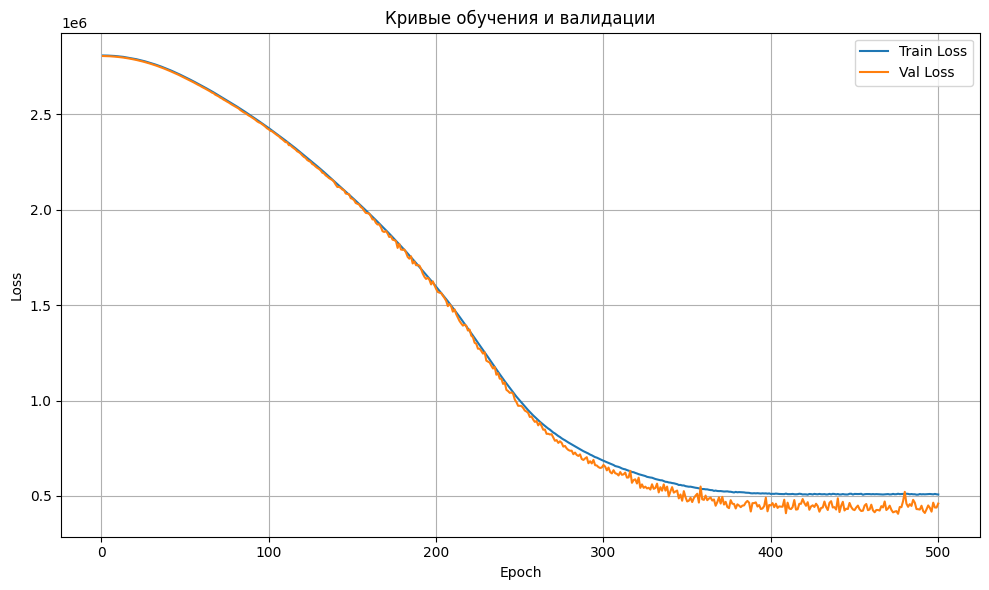

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Кривые обучения и валидации')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Вывод

Обе кривые идут практически идентично, значит, нет особых признаков переобучения (валидационный лосс даже чуть ниже тренировочного). Модель стабильно учится до ~350–400 эпох, после чего лоссы почти не падают и выходят на плато.

Обучение проходит стабильно, без разрыва между train/val.

Дальше после ~350 эпок прирост качества минимален.